In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

plt.style.use('ggplot')

## Data generation

We generate a dataset inspired by the motivating example. In particular, we assume that there are two types of displays. Displays of type A influence user's behavior and increase conversion probability. On the other hand, displays of type B do not influence conversion probability at all. However, they always appear right before conversion. We capture the essence of this example by assuming that there are only two types of scenarios. The first type of scenario, $s_1$ consists of a single display A and happens with probability $p$. The second type of scenario, $s_2$ consists of a display A followed by a display B and happens with probability $1-p$. In both cases, a conversion happens with probability 0.5. With our notation, this means that $V(s_1)=V(s_2)=0.5$.

In [2]:
def generate_dataset(n_samples=10000, seed=None, scenario_1_proba=1/3):
  np.random.seed(seed)

  scenario_1_conversion_proba = 0.5
  scenario_2_conversion_proba = 0.6

  data_rows = []
  for i in range(n_samples):
    sampled_scenario = np.random.choice([1, 2], p=[scenario_1_proba, 1 - scenario_1_proba])
    if sampled_scenario == 1:
      data_rows += [
        {"uid": i, "features": [1, 0], "conversion": int(np.random.rand() < scenario_1_conversion_proba), "display type": "Display A"}
      ]
    elif sampled_scenario == 2:
      data_rows += [
        {"uid": i, "features": [1, 0], "conversion": 0, "display type": "Display A"},
        {"uid": i, "features": [0, 1], "conversion": int(np.random.rand() < scenario_2_conversion_proba), "display type": "Display B"},
      ]

  data = pd.DataFrame(data_rows)

  total_uid_rewards_df = data.groupby('uid').agg({'conversion': 'sum'}).reset_index()
  total_uid_rewards_df.columns = ['uid', 'total_uid_rewards']
  data = data.merge(total_uid_rewards_df)

  return data

generate_dataset(n_samples=5).head()

,uid,features,conversion,display type,total_uid_rewards
0,0,"[1, 0]",0,Display A,1
1,0,"[0, 1]",1,Display B,1
2,1,"[1, 0]",0,Display A,1
3,1,"[0, 1]",1,Display B,1
4,2,"[1, 0]",1,Display A,1


## Additivity likelihood
We call additivity empirical likelihood 

$$
f(\nu) = \sum_{n = 1}^N \Bigg\{ V(s_n) \cdot \log \bigg( \sum_{i = 1}^{\ell(s)} \nu({s_n}^i) \bigg) - \sum_{i = 1}^{\ell(s)} \nu({s_n}^i) \Bigg\}
$$

In [16]:
def additivity_likelihood(model_predictions, timeline_ids, uid_rewards):
  # Gather the attributions per timeline and obtain the sum of the predictions per timeline
  predictions_per_display = pd.DataFrame({
      'timeline_id': timeline_ids,
      'prediction': model_predictions,
      'uid_reward': uid_rewards,
  })

  sum_predictions_by_timeline = (
    predictions_per_display
    .groupby('timeline_id')
    .agg(sum_predictions=('prediction', 'sum'), uid_reward=('uid_reward', 'first'))
    .reset_index()
  )
    
  additivity_llh = (
    sum_predictions_by_timeline['uid_reward'] 
    * np.log(sum_predictions_by_timeline['sum_predictions'])
    - sum_predictions_by_timeline['sum_predictions']
  )
  
  return additivity_llh.mean()

## Fixed point algorithm

We are implementing the following fixed-point algorithm

1. Generate dataset
   $$ \mathcal{D}^{(k + 1)} \;\; = \;\; \big\{
   (x, y) = \big((s_n)^j, \mu^{(k)}(j, s_n) \big) \text{ for } n \in [N] \text{ and } j \in [\ell(s_n)] 
   \big\}$$
  
2. With an averaging or a ML algorithm, train $\nu^{(k + 1)}$ on $\mathcal{D}^{(k + 1)}$ 
   $$ \nu^{(k + 1)} \;\; = \;\; (s) \mapsto \mathbb{E}_{(x, y) \in \mathcal{D}^{(k + 1)}} \big[ y\; | \; x=s \big] $$

3. Set $\mu$ with fixed-point characterization 
   $$\mu^{(k + 1)} \;\; = \;\; (i, s) \mapsto \frac{\nu^{(k + 1)}(s^i)}{\sum_{j = 1}^{\ell(s)} \nu^{(k + 1)}(s^j)} V(s)$$

In [17]:
def average_display_valuation_per_display_type(dataset):
  return (
    dataset.groupby('display type')
      .agg(scenario_valuation=('labels', 'mean'))
      .reset_index()
  )


def compute_display_valuations_by_averaging(dataset):
  scenario_valuation = average_display_valuation_per_display_type(dataset)
  return dataset.merge(scenario_valuation, on='display type', how='left')


def run_one_iteration(original_dataset, compute_display_valuations):
  current_dataset = original_dataset.copy()
  
  # Step 2, compute valuations
  current_dataset = compute_display_valuations(current_dataset)
  
  # Step 3, compute new labels proportionnaly to the display valuations
  total_uid_valuation = (
      current_dataset
      .groupby('uid')
      .agg(total_uid_valuation=('scenario_valuation', 'sum'))
      .reset_index()
  )
  
  merged_dataset = current_dataset.merge(total_uid_valuation, on='uid', how='left')
  current_dataset['labels'] = (
    merged_dataset['scenario_valuation']
    / merged_dataset['total_uid_valuation']
    * merged_dataset['total_uid_rewards']
  )
  
  return current_dataset[original_dataset.columns]


def compute_metrics(original_dataset, compute_display_valuations):
  current_dataset = original_dataset.copy()
  
  scenario_valuation = average_display_valuation_per_display_type(current_dataset)
  scenario_valuation_dict = {
    row['display type']: row['scenario_valuation']
    for _, row in scenario_valuation.iterrows()
  }
  
  dataset_with_valuations = current_dataset.merge(scenario_valuation, on='display type', how='left')
    
  current_additivity_likelihood = additivity_likelihood(
      dataset_with_valuations['scenario_valuation'], 
      dataset_with_valuations['uid'], 
      dataset_with_valuations['total_uid_rewards']
  )
  
  return scenario_valuation_dict, current_additivity_likelihood

In [18]:
current_dataset = generate_dataset(seed=2390)
# Initialize with last touch: last display beforethe conversion gets all credit
current_dataset['labels'] = current_dataset['conversion'].values

scenario_valuations = []
additivity_likelihoods = []
for _ in range(30):
  current_dataset = run_one_iteration(current_dataset, compute_display_valuations_by_averaging)
  scenario_valuation, current_additivity_likelihood = compute_metrics(current_dataset, compute_display_valuations_by_averaging)
  scenario_valuations += [scenario_valuation]
  additivity_likelihoods += [current_additivity_likelihood]

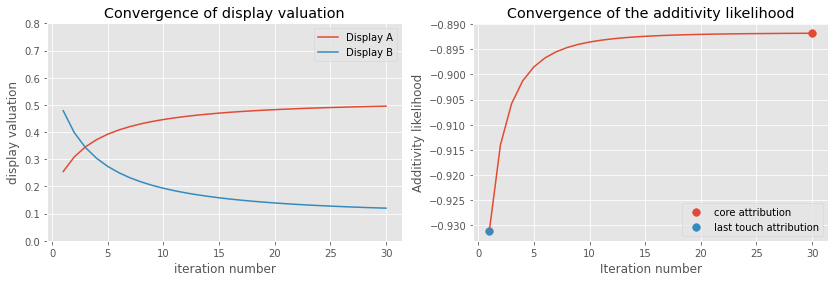

In [29]:
def plot_scenario_valuation(scenario_valuations, ax):
  display_types = sorted(list(scenario_valuations[0].keys()))
  for display_type in display_types:
      ax.plot(
          range(1, len(scenario_valuations) + 1), 
          [valuations[display_type] for valuations in scenario_valuations], 
          label=display_type
      )

  ax.set_title('Convergence of display valuation')
  ax.set_ylabel('display valuation')
  ax.set_xlabel('iteration number')
  #ax.set_xlim((ax.get_xlim()[0], ax.get_xlim()[1] * 1.2))  # Add some space on the right
  ax.set_ylim([0., 0.8])
  ax.legend(loc='upper right')

def plot_additivity_likelihood(additivity_likelihoods, ax):
  ax.set_title('Convergence of the additivity likelihood')
  ax.plot(range(1, len(additivity_likelihoods) + 1), additivity_likelihoods)
  ax.set_ylabel('Additivity likelihood')
  ax.set_xlabel('Iteration number')

  llh_init = additivity_likelihoods[0]
  llh_conv = additivity_likelihoods[-1]
  ax.scatter(len(additivity_likelihoods), llh_conv, s=60, label='core attribution', c='C0')
  ax.scatter(1, llh_init, s=60, label='last touch attribution', c='C1')
  ax.legend()

def plot_metrics(scenario_valuations, additivity_likelihoods):
  fig, axes = plt.subplots(1, 2, figsize=(14, 4))
  plot_scenario_valuation(scenario_valuations, axes[0])
  plot_additivity_likelihood(additivity_likelihoods, axes[1])
  
plot_metrics(scenario_valuations, additivity_likelihoods)

In [30]:
# Saving figures for paper
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_scenario_valuation(scenario_valuations, ax)
fig.subplots_adjust(bottom=0.15, left=0.15, top=0.95, right=0.95)
ax.set_title(None)
plt.savefig('scenario_valuation_with_averaging.pdf')
plt.close(fig)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_additivity_likelihood(additivity_likelihoods, ax)
fig.subplots_adjust(bottom=0.15, left=0.15, top=0.95, right=0.95)
ax.set_title(None)
plt.savefig('additivity_likelihoods_with_averaging.pdf')
plt.close(fig)

## With a machine learning algorithm (Logistic regression)

We choose Logistic regression from scikit-learn as our ML algorithm. The logistic regression loss that we minimize is

$$
l(y, p) = \mathbb{1}_{y = 1} \log(p) + \mathbb{1}_{y = 0} \log(1 - p)
$$

However, our fixed-point algorithm will make appear continuous labels ($y$ is the result of the internal attribution $\mu$) that cannot be fit with scikit-learn's logistic regression. Indeed, this logisitic regression can only take 0-1 labels as input.

A basic extension of logistic regression to learn with a continuous label $y \in [0, 1]$, consisits in minimizing the binomial loss that writes:

$$
l(y, p) = y \log(p) + (1 - y) \log(1 - p)
$$

In order to minimize this loss with a logistic regression optimizer, we generate a new dataset in which we duplicate the rows and assign them a weight : a "positive" row a label 1 and a weight $y$ and a "negative" row with a label 0 and a weight $1 - y$. On such a dataset, minimizing the logistic regression loss is equivalent to minimizing the binomial loss.

In [8]:
class CountinuousLogisticRegression(LogisticRegression):
  
  @staticmethod
  def from_countinuous_to_weighted_binary_labels(labels, features):
    """Transforms a dataset with continuous labels into a bigger dataset with weighted 
    binary labels. See explanation above.
    """
    weigths_positive = labels
    weigths_negative = 1 - labels
    label_positive = np.ones_like(labels)
    label_negative = np.zeros_like(labels)

    weights = np.hstack((weigths_positive, weigths_negative))
    weighted_labels = np.hstack((label_positive, label_negative))
    weighted_features = np.vstack((features, features))

    return weighted_labels, weighted_features, weights
  
  def fit(self, X, y):
    # 1. Generate dataset, use continuous labels to weighted dataset trick
    weighted_labels, weighted_features, weights = self.from_countinuous_to_weighted_binary_labels(y, X)

    # 2. Train model
    return LogisticRegression.fit(self, weighted_features, weighted_labels, sample_weight=weights)

In [9]:
def compute_display_valuations_with_logistic_regression(dataset):
  current_dataset = dataset.copy()
  
  labels = current_dataset['labels'].values
  features = np.vstack(current_dataset['features'].values)
  
  model = CountinuousLogisticRegression(max_iter=1000, penalty='none')
  model.fit(features, labels)
  model_predictions = model.predict_proba(features)[:, 1]
  
  current_dataset['scenario_valuation'] = model_predictions
  return current_dataset

In [26]:
current_dataset = generate_dataset(seed=2390)
# Initialize with last click
current_dataset['labels'] = current_dataset['conversion'].values

scenario_valuations = []
additivity_likelihoods = []
for _ in range(30):
  current_dataset = run_one_iteration(current_dataset, compute_display_valuations_with_logistic_regression)
  scenario_valuation, current_additivity_likelihood = compute_metrics(current_dataset, compute_display_valuations_with_logistic_regression)
  scenario_valuations += [scenario_valuation]
  additivity_likelihoods += [current_additivity_likelihood]

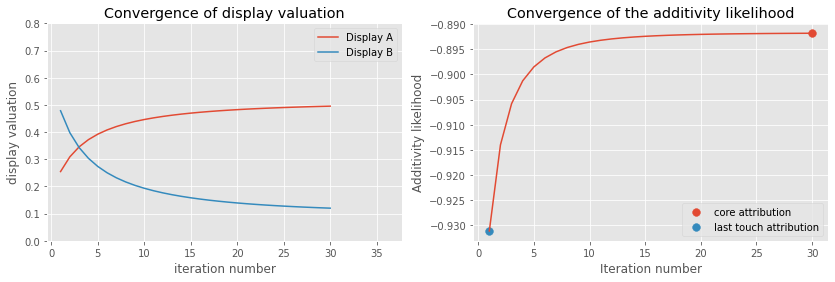

In [27]:
plot_metrics(scenario_valuations, additivity_likelihoods)

## Data distribution robustness

In [12]:
valuations_given_proba_core_attribution = {}
valuations_given_proba_last_touch = {}
scenario_1_probas = np.linspace(0, 1, 11)[1:-1]

for scenario_1_proba in scenario_1_probas:
  current_dataset = generate_dataset(seed=2390, scenario_1_proba=scenario_1_proba)
  # Initialize with last touch: last display beforethe conversion gets all credit
  current_dataset['labels'] = current_dataset['conversion'].values

  scenario_valuations = []
  additivity_likelihoods = []
  for i in range(100):
    current_dataset = run_one_iteration(current_dataset, compute_display_valuations_by_averaging)
    scenario_valuation, _ = compute_metrics(current_dataset, compute_display_valuations_by_averaging)

    if i == 0:
      valuations_given_proba_last_touch[scenario_1_proba] = scenario_valuation

  valuations_given_proba_core_attribution[scenario_1_proba] = scenario_valuation

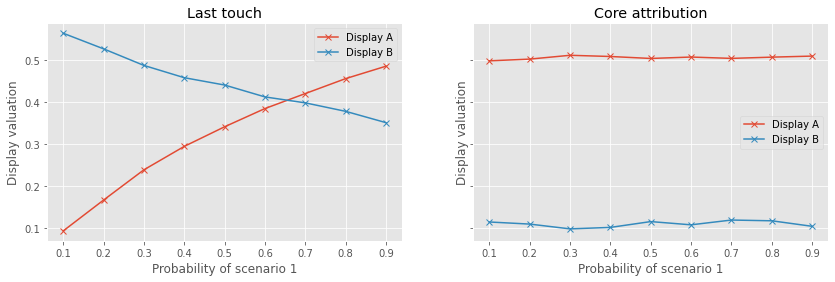

In [28]:
def plot_display_valuation_given_scenario_proba(valuations_given_proba, ax):
  for display in ['Display A', 'Display B']:
    ax.plot(
      scenario_1_probas, 
      [valuations_given_proba[p][display] for p in scenario_1_probas], 
      label=f'{display}', marker='x'
    )

    ax.legend()
    ax.set_xlabel('Probability of scenario 1')
    ax.set_ylabel('Display valuation')

fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
plot_display_valuation_given_scenario_proba(valuations_given_proba_last_touch, axes[0])
axes[0].set_title('Last touch')
plot_display_valuation_given_scenario_proba(valuations_given_proba_core_attribution, axes[1])
axes[1].set_title('Core attribution')
None

In [14]:
# Saving figures for paper
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_display_valuation_given_scenario_proba(valuations_given_proba_last_touch, ax)
fig.subplots_adjust(bottom=0.15, left=0.15, top=0.95, right=0.95)
plt.savefig('distributional_robustness_last_touch.pdf')
plt.close(fig)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_display_valuation_given_scenario_proba(valuations_given_proba_core_attribution, ax)
fig.subplots_adjust(bottom=0.15, left=0.15, top=0.95, right=0.95)
plt.savefig('distributional_robustness_core_attribution.pdf')
plt.close(fig)